In [1]:
import numpy

import scipy
from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('error', category=UnicodeWarning)

import time

# K-means

In [2]:
def split_nearest(x, centers):
    '''Split x to groups,
    the nearest center for each element of i-th group is centers[i]'''
    assert len(x.shape) == 2
    cl = distance_matrix(x, centers, p=2).argmin(axis=1)
    return [x[cl == i] for i in range(centers.shape[0])]

class k_means:
    def __init__(self, k, init=None):
        if init is None:
            init = self._random_choice
        self.init = init
        self.nclusters = k
        self.centers = None

    @staticmethod
    def _random_choice(n, x):
        return (numpy.random.default_rng(seed=numpy.random.randint(0, 2**32))
                .choice(x, size=n, replace=False))

    def train(self, x):
        # get random centers
        self.centers = self.init(self.nclusters, x)
        prev = None
        while (prev != self.centers).all():
            cl = self.clusters(x)
            # new centers are means of each group
            new = numpy.array([
                    x.mean(axis=0) if len(x) else self.centers[i]
                    for i, x in enumerate(cl)])
            self.centers, prev = new, self.centers
        return self

    def __call__(self, x):
        assert self.centers is not None
        return distance_matrix(x, self.centers, p=2).argmin(axis=1)
    
    def clusters(self, x):
        assert len(x.shape) == 2
        cl = self(x)
        return [x[cl == i] for i in range(self.centers.shape[0])]

### testing

In [3]:
def init_farthest(n, x):
    y = (numpy.random.default_rng(seed=numpy.random.randint(0, 2**32))
            .choice(x, size=1))
    for i in range(n-1):
        y = numpy.concatenate([
                x[distance_matrix(x, y, p=2).min(axis=1).argmax()].reshape(1, -1),
                y])
    return y

In [4]:
def clustering_loss(clusters):
    avg = 0
    for c in clusters:
        n = len(c)
        avg += distance_matrix(c, c, p=2).mean() / n
    cc = numpy.concatenate(clusters)
    n = len(cc)
    return avg#/ ((distance_matrix(cc, cc, p=2).mean()) / n)

In [5]:
def gen1(N=100):
    st = numpy.array([1.5 + abs(numpy.random.randn(N)) * 3,
            numpy.random.randn(N)-3])
    st[1] /= st[0]
    x = numpy.concatenate([numpy.random.randn(N, 2)/3,
            2 + numpy.random.randn(N, 2)/3,
            st.T])
    return x

def gen2(N=100, std=1/3, r=1):
    alp = numpy.random.rand(N) * 2 * numpy.pi
    r = r + numpy.random.randn(N) * std
    x = numpy.array([r * numpy.cos(alp), r * numpy.sin(alp)]).T
    return x

2562393602
0.08840564546033769
0.04728037225212109


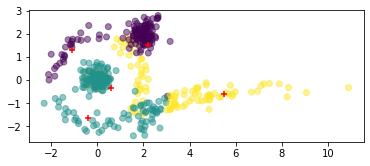

In [12]:
if 1:
    s = numpy.random.randint(0, 2**32-1)
    print(s)
    numpy.random.seed(s)
else:
    numpy.random.seed(3368459579)

kcl = k_means(3, init_farthest)
xx = [numpy.concatenate([gen2(100, 1/5, 2), gen2(100, 1/4, 0)]),
      gen1(100)]
for x in xx:
    kcl.train(x)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(x[:, 0], x[:, 1], c=kcl(x), alpha=0.5)
    plt.scatter(kcl.centers[:, 0], kcl.centers[:, 1], c='red', marker='+')
    print(clustering_loss(kcl.clusters(x)))

In [7]:
for kcl in [k_means(3), k_means(3, init_farthest)]:
    for i, x in enumerate(xx):
        gg = x #* (1+50*i)
        kcl.train(gg)
        print(sum([(kcl.train(gg), clustering_loss(kcl.clusters(gg)))[1]
                for i in range(1000)]))
    print()

86.51406761912465
45.02250952677635

88.60420754212184
93.20021242630985



# Time

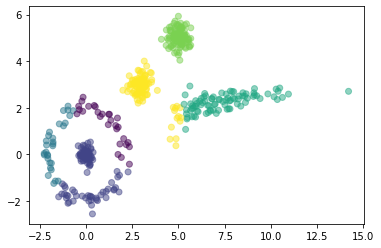

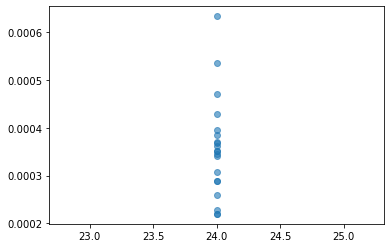

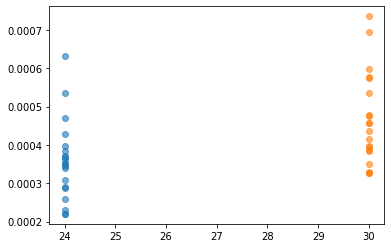

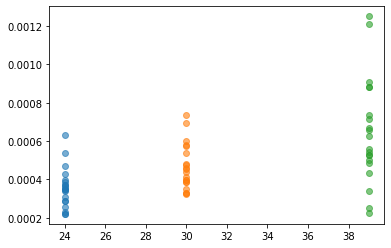

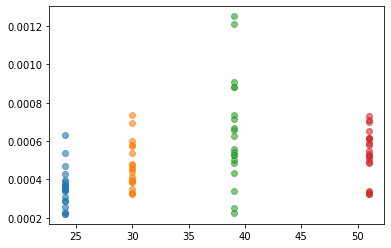

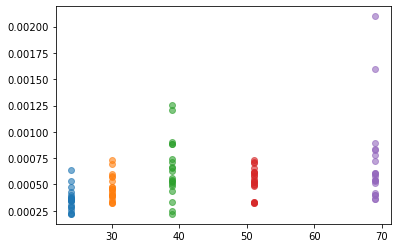

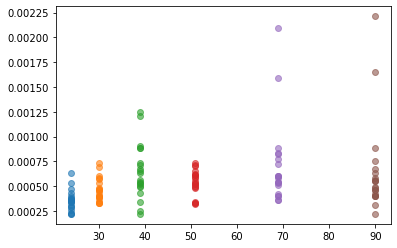

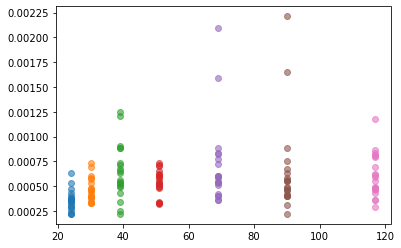

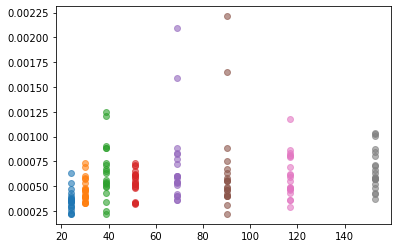

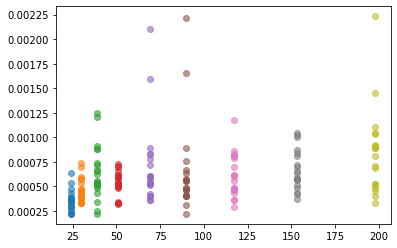

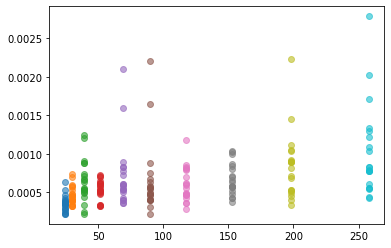

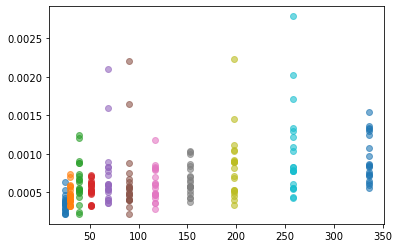

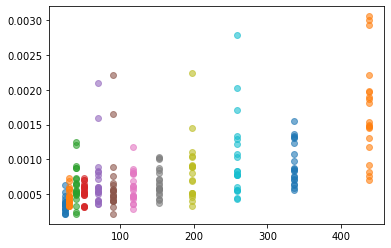

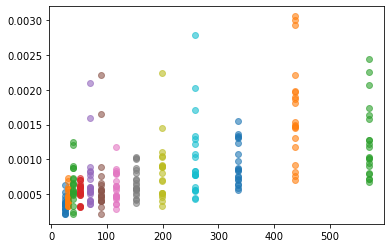

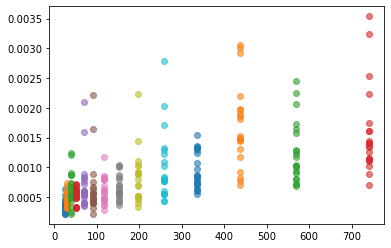

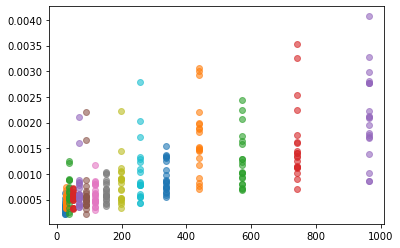

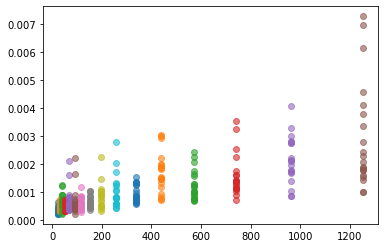

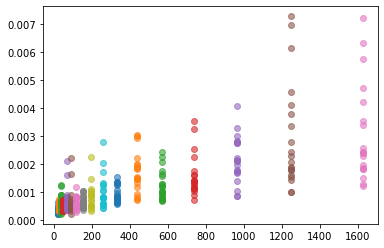

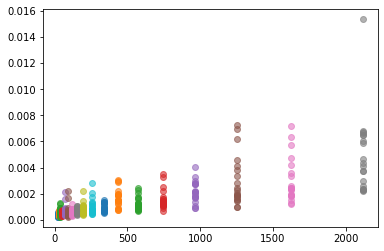

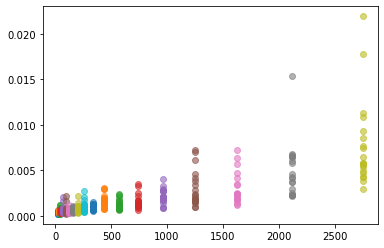

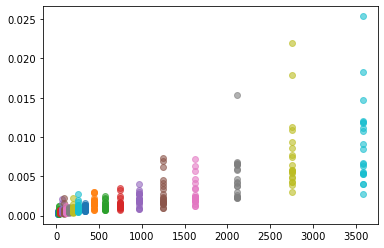

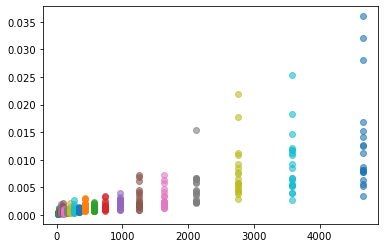

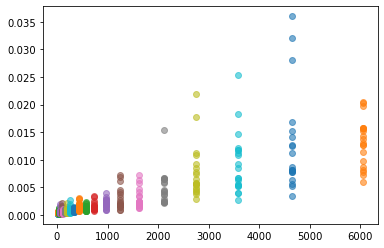

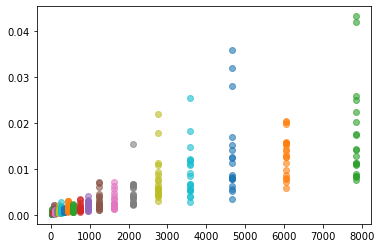

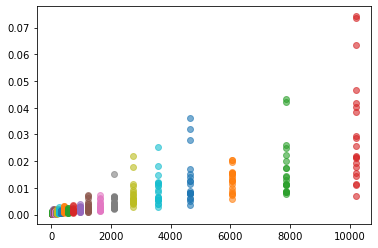

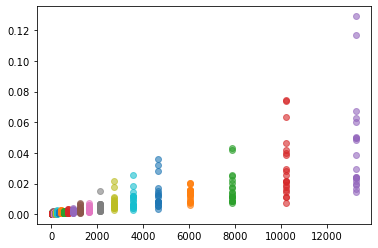

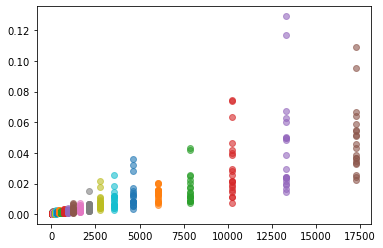

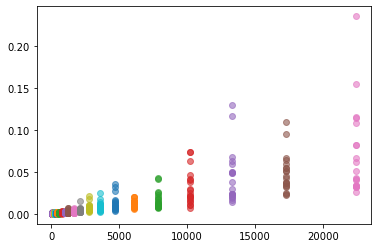

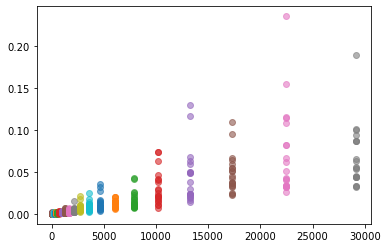

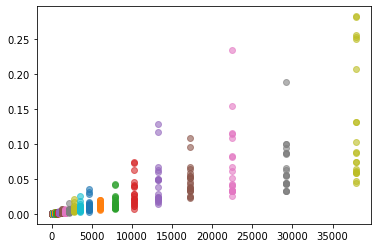

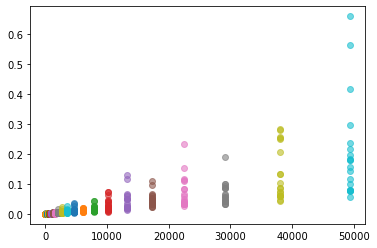

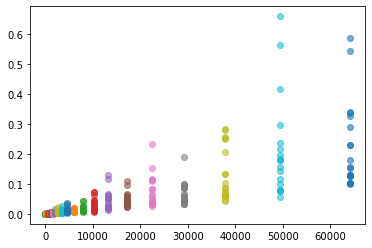

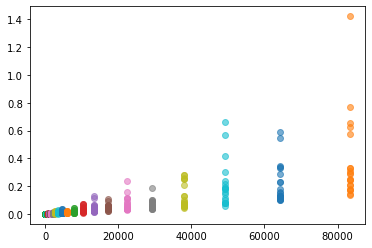

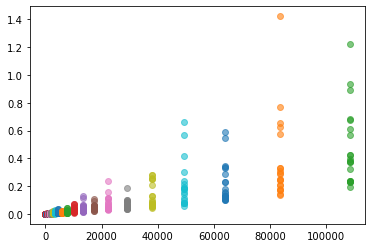

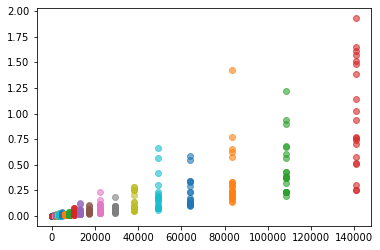

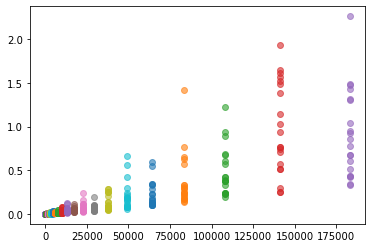

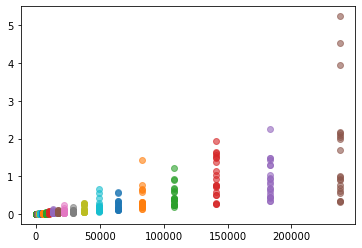

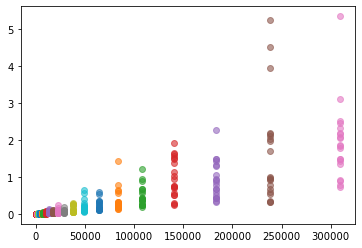

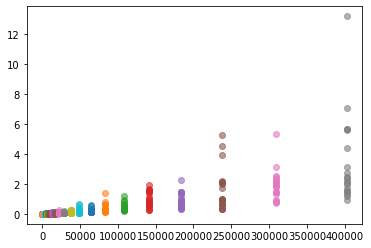

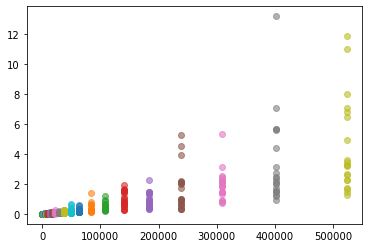

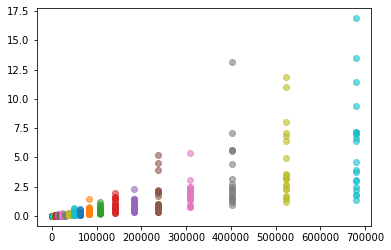

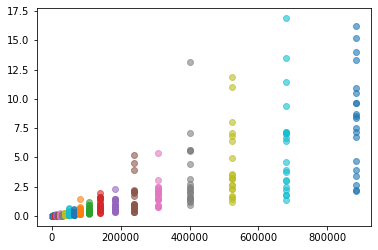

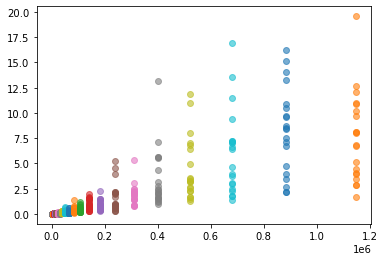

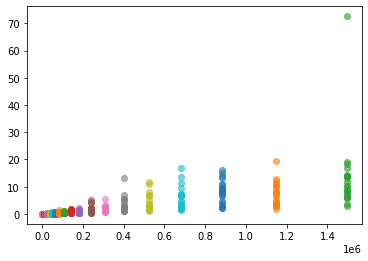

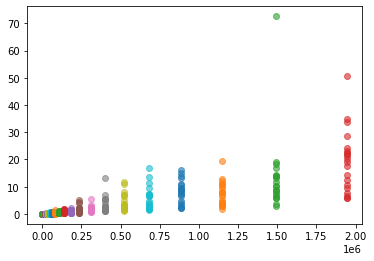

In [ ]:
N = 100
xx = numpy.concatenate([gen2(N, 1/5, 2), gen2(N, 1/4, 0), 3 + gen1(N)])
plt.scatter(xx[:, 0], xx[:, 1], c=k_means(6).train(xx)(xx), alpha=0.5)
plt.show()

t = []
sz = 3 * numpy.floor(1.3 ** numpy.arange(8, 53)).astype(numpy.int64)
for N in sz:
    assert N%3 == 0
    xx = numpy.concatenate([gen2(N//3, 1/5, 2), gen2(N//3, 1/4, 0), 3 + gen1(N//3)])
    kcl = k_means(6)
    t.append([])
    for i in range(20):
        t[-1].append(time.time())
        kcl.train(xx)
        t[-1][-1] = time.time() - t[-1][-1]
    plt.cla()
    for s, tt in zip(sz[:len(t)], t):
        plt.scatter(s * numpy.ones(len(t[-1])), tt, alpha=0.6)
    plt.show()
plt.scatter(xx[:, 0], xx[:, 1], c=kcl(xx), alpha=0.5)